# Autoencoders in SciKeras

Autencoders are an approach to use nearual networks to distill data into it's most important features, thereby compressing the data. We will be following the [Keras tutorial](https://blog.keras.io/building-autoencoders-in-keras.html) on the topic, which goes much more in depth and breadth than we will here. You are highly encouraged to check out that tutorial if you want to learn about autoencoders in the general sense.

## Table of contents

* [1. Setup](#1.-Setup)
* [2. Data](#2.-Data)
* [3. Define Keras Model](#3.-Define-Keras-Model)
* [4. Training](#4.-Training)
* [5. Explore Results](#5.-Explore-Results)

## 1. Setup

In [1]:
try:
    import scikeras
except ImportError:
    !python -m pip install scikeras

Silence TensorFlow logging to keep output succinct.

In [2]:
import warnings
from tensorflow import get_logger
get_logger().setLevel('ERROR')
warnings.filterwarnings("ignore", message="Setting the random state for TF")

In [3]:
import numpy as np
from scikeras.wrappers import KerasClassifier, KerasRegressor
from tensorflow import keras

## 2. Data

We load the dataset from the Keras tutorial. The dataset consists of images of cats and dogs.

In [4]:
from tensorflow.keras.datasets import mnist
import numpy as np


(x_train, _), (x_test, _) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

(60000, 784)
(10000, 784)


## 3. Define Keras Model

We will be defining a very simple autencoder. We define _three_ model building methods:

1. One to build a full end-to-end autoencoder.
2. One to create a model that includes only the encoder portion.
3. One that creates a model that includes only the decoder portion.

The only variable we give our model is the encoding dimensions, which will be a hyperparemter of our final transformer.

In [5]:
from tensorflow import keras


def get_fit_model(encoding_dim: int) -> keras.Model:
    """Get an autoencoder.

    This autoencoder compresses a 28x28 image (784 pixels) down to a feature of length
    `encoding_dim`, and tries to reconstruct the input image from that vector.
    """
    input_img = keras.Input(shape=(784,), name="input")
    encoded = keras.layers.Dense(encoding_dim, activation='relu', name="encoded")(input_img)
    decoded = keras.layers.Dense(784, activation='sigmoid', name="output")(encoded)
    autoencoder_model = keras.Model(input_img, decoded)
    return autoencoder_model

def get_tf_model(fit_model: keras.Model) -> keras.Model:
    """Get an encoder model.

    We do this by extracting the encoding layer from the fitted autoencoder model.
    """
    return keras.Model(fit_model.get_layer("input").input, fit_model.get_layer("encoded").output)

def get_inverse_tf_model(fit_model: keras.Model, encoding_dim: int) -> keras.Model:
    """Get an deencoder model.

    We do this by extracting the deencoding layer from the fitted autoencoder model
    and adding a new Keras input layer.
    """
    encoded_input = keras.Input(shape=(encoding_dim,))
    output = fit_model.get_layer("output")(encoded_input)
    return keras.Model(encoded_input, output)

Next we create a class that that will enable the `transform` and `fit_transform` methods, as well as integrating all three of our models into a single estimator.

In [6]:
from sklearn.base import TransformerMixin, clone
from scikeras.wrappers import BaseWrapper


class KerasTransformer(BaseWrapper, TransformerMixin):
    """A class that enables transform and fit_transform.
    """

    def __init__(self, *args, tf_est: BaseWrapper = None, inv_tf_est: BaseWrapper = None, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.tf_est = tf_est
        self.inv_tf_est = inv_tf_est


    def fit(self, X, sample_weight=None):
        super().fit(X=X, y=X, sample_weight=sample_weight)
        self.tf_est_ = clone(self.tf_est)
        self.inv_tf_est_ = clone(self.inv_tf_est)
        self.tf_est_.set_params(fit_model=self.model_)
        self.inv_tf_est_.set_params(fit_model=self.model_, encoding_dim=self.encoding_dim)
        X = self.feature_encoder_.transform(X)
        self.tf_est_.initialize(X=X)
        X_tf = self.tf_est_.predict(X=X)
        self.inv_tf_est_.initialize(X_tf)
        return self

    def transform(self, X):
        X = self.feature_encoder_.transform(X)
        X_tf = self.tf_est_.predict(X)
        return X_tf
    
    def inverse_transform(self, X_tf):
        X = self.inv_tf_est_.predict(X_tf)
        X = self.feature_encoder_.inverse_transform(X)
        return X

Next, we wrap the Keras Model with Scikeras. Note that for our encoder/decoder estimators, we do not need to provide a loss function since no training will be done. We do however need to have the `fit_model` and `encoding_dim` so that these will be settable by `BaseWrapper.set_params`.

In [7]:
tf_est = BaseWrapper(model=get_tf_model, fit_model=None, verbose=0)
inv_tf_est = BaseWrapper(model=get_inverse_tf_model, fit_model=None, encoding_dim=None, verbose=0)
autoencoder = KerasTransformer(model=get_fit_model, tf_est=tf_est, inv_tf_est=inv_tf_est, loss="binary_crossentropy", encoding_dim=32, epochs=5)

## 4. Training

To train the model, we pass the input images as both the features and the target. This will train the layers to compress the data as accurately as possible between the encoder and decoder. Note that we only pass the `X` parameter, since we defined the mapping `y=X` in `KerasTransformer.fit` above.

In [8]:
_ = autoencoder.fit(X=x_train)

Epoch 1/5


   1/1875 [..............................] - ETA: 13:06 - loss: 0.6946

  30/1875 [..............................] - ETA: 3s - loss: 0.5377   

  61/1875 [..............................] - ETA: 3s - loss: 0.4570

  88/1875 [>.............................] - ETA: 3s - loss: 0.4201

 118/1875 [>.............................] - ETA: 3s - loss: 0.3932

 149/1875 [=>............................] - ETA: 2s - loss: 0.3733

 180/1875 [=>............................] - ETA: 2s - loss: 0.3578

 210/1875 [==>...........................] - ETA: 2s - loss: 0.3455

 247/1875 [==>...........................] - ETA: 2s - loss: 0.3328

 278/1875 [===>..........................] - ETA: 2s - loss: 0.3238

 308/1875 [===>..........................] - ETA: 2s - loss: 0.3161

 338/1875 [====>.........................] - ETA: 2s - loss: 0.3092

 369/1875 [====>.........................] - ETA: 2s - loss: 0.3028

 401/1875 [=====>........................] - ETA: 2s - loss: 0.2968

 436/1875 [=====>........................] - ETA: 2s - loss: 0.2909

 472/1875 [======>.......................] - ETA: 2s - loss: 0.2853

 504/1875 [=======>......................] - ETA: 2s - loss: 0.2808

 531/1875 [=======>......................] - ETA: 2s - loss: 0.2773

 560/1875 [=======>......................] - ETA: 2s - loss: 0.2737

 590/1875 [========>.....................] - ETA: 2s - loss: 0.2702

 620/1875 [========>.....................] - ETA: 2s - loss: 0.2669

 651/1875 [=========>....................] - ETA: 2s - loss: 0.2637

 681/1875 [=========>....................] - ETA: 1s - loss: 0.2608

 711/1875 [==========>...................] - ETA: 1s - loss: 0.2580

 739/1875 [==========>...................] - ETA: 1s - loss: 0.2555

 767/1875 [===========>..................] - ETA: 1s - loss: 0.2532

 797/1875 [===========>..................] - ETA: 1s - loss: 0.2507

 826/1875 [============>.................] - ETA: 1s - loss: 0.2485

 856/1875 [============>.................] - ETA: 1s - loss: 0.2463

 885/1875 [=============>................] - ETA: 1s - loss: 0.2442

 919/1875 [=============>................] - ETA: 1s - loss: 0.2419

 954/1875 [==============>...............] - ETA: 1s - loss: 0.2396

 984/1875 [==============>...............] - ETA: 1s - loss: 0.2377

1018/1875 [===============>..............] - ETA: 1s - loss: 0.2357

1053/1875 [===============>..............] - ETA: 1s - loss: 0.2336

1082/1875 [================>.............] - ETA: 1s - loss: 0.2320

1111/1875 [================>.............] - ETA: 1s - loss: 0.2305

1144/1875 [=================>............] - ETA: 1s - loss: 0.2288

1176/1875 [=================>............] - ETA: 1s - loss: 0.2272

1204/1875 [==================>...........] - ETA: 1s - loss: 0.2258

1237/1875 [==================>...........] - ETA: 1s - loss: 0.2242

1271/1875 [===================>..........] - ETA: 0s - loss: 0.2227

1308/1875 [===================>..........] - ETA: 0s - loss: 0.2211

1338/1875 [====================>.........] - ETA: 0s - loss: 0.2198

1369/1875 [====================>.........] - ETA: 0s - loss: 0.2185

1400/1875 [=====================>........] - ETA: 0s - loss: 0.2172

1437/1875 [=====================>........] - ETA: 0s - loss: 0.2158

1469/1875 [======================>.......] - ETA: 0s - loss: 0.2146

1500/1875 [=======================>......] - ETA: 0s - loss: 0.2134

1529/1875 [=======================>......] - ETA: 0s - loss: 0.2124

1555/1875 [=======================>......] - ETA: 0s - loss: 0.2115

1586/1875 [========================>.....] - ETA: 0s - loss: 0.2104

1614/1875 [========================>.....] - ETA: 0s - loss: 0.2095

1643/1875 [=========================>....] - ETA: 0s - loss: 0.2085

1672/1875 [=========================>....] - ETA: 0s - loss: 0.2076

1708/1875 [==========================>...] - ETA: 0s - loss: 0.2064

1740/1875 [==========================>...] - ETA: 0s - loss: 0.2055

1767/1875 [===========================>..] - ETA: 0s - loss: 0.2046

1800/1875 [===========================>..] - ETA: 0s - loss: 0.2037

1834/1875 [============================>.] - ETA: 0s - loss: 0.2027

1867/1875 [============================>.] - ETA: 0s - loss: 0.2018

1875/1875 [==============================] - 3s 2ms/step - loss: 0.2015


Epoch 2/5
   1/1875 [..............................] - ETA: 3s - loss: 0.1073

  29/1875 [..............................] - ETA: 3s - loss: 0.1098

  56/1875 [..............................] - ETA: 3s - loss: 0.1105

  84/1875 [>.............................] - ETA: 3s - loss: 0.1105

 104/1875 [>.............................] - ETA: 3s - loss: 0.1104

 132/1875 [=>............................] - ETA: 3s - loss: 0.1104

 163/1875 [=>............................] - ETA: 3s - loss: 0.1103

 191/1875 [==>...........................] - ETA: 3s - loss: 0.1102

 216/1875 [==>...........................] - ETA: 3s - loss: 0.1102

 245/1875 [==>...........................] - ETA: 3s - loss: 0.1101

 274/1875 [===>..........................] - ETA: 2s - loss: 0.1100

 302/1875 [===>..........................] - ETA: 2s - loss: 0.1099

 330/1875 [====>.........................] - ETA: 2s - loss: 0.1098

 358/1875 [====>.........................] - ETA: 2s - loss: 0.1098

 386/1875 [=====>........................] - ETA: 2s - loss: 0.1097

 413/1875 [=====>........................] - ETA: 2s - loss: 0.1096

 448/1875 [======>.......................] - ETA: 2s - loss: 0.1095

 478/1875 [======>.......................] - ETA: 2s - loss: 0.1095

 505/1875 [=======>......................] - ETA: 2s - loss: 0.1094

 536/1875 [=======>......................] - ETA: 2s - loss: 0.1093

 569/1875 [========>.....................] - ETA: 2s - loss: 0.1093

 604/1875 [========>.....................] - ETA: 2s - loss: 0.1092

 634/1875 [=========>....................] - ETA: 2s - loss: 0.1091

 666/1875 [=========>....................] - ETA: 2s - loss: 0.1090

 699/1875 [==========>...................] - ETA: 2s - loss: 0.1089

 729/1875 [==========>...................] - ETA: 1s - loss: 0.1089

 757/1875 [===========>..................] - ETA: 1s - loss: 0.1088

 786/1875 [===========>..................] - ETA: 1s - loss: 0.1087

 816/1875 [============>.................] - ETA: 1s - loss: 0.1087

 846/1875 [============>.................] - ETA: 1s - loss: 0.1086

 876/1875 [=============>................] - ETA: 1s - loss: 0.1085

 906/1875 [=============>................] - ETA: 1s - loss: 0.1085

 936/1875 [=============>................] - ETA: 1s - loss: 0.1084

 969/1875 [==============>...............] - ETA: 1s - loss: 0.1083

 999/1875 [==============>...............] - ETA: 1s - loss: 0.1083

1035/1875 [===============>..............] - ETA: 1s - loss: 0.1082

1067/1875 [================>.............] - ETA: 1s - loss: 0.1081

1096/1875 [================>.............] - ETA: 1s - loss: 0.1080

1133/1875 [=================>............] - ETA: 1s - loss: 0.1080

1170/1875 [=================>............] - ETA: 1s - loss: 0.1079

1204/1875 [==================>...........] - ETA: 1s - loss: 0.1078

1234/1875 [==================>...........] - ETA: 1s - loss: 0.1078

1264/1875 [===================>..........] - ETA: 1s - loss: 0.1077

1290/1875 [===================>..........] - ETA: 0s - loss: 0.1076

1318/1875 [====================>.........] - ETA: 0s - loss: 0.1076

1347/1875 [====================>.........] - ETA: 0s - loss: 0.1075

1382/1875 [=====================>........] - ETA: 0s - loss: 0.1075

1414/1875 [=====================>........] - ETA: 0s - loss: 0.1074

1445/1875 [======================>.......] - ETA: 0s - loss: 0.1073

1479/1875 [======================>.......] - ETA: 0s - loss: 0.1073

1511/1875 [=======================>......] - ETA: 0s - loss: 0.1072

1547/1875 [=======================>......] - ETA: 0s - loss: 0.1072

1584/1875 [========================>.....] - ETA: 0s - loss: 0.1071

1620/1875 [========================>.....] - ETA: 0s - loss: 0.1070

1656/1875 [=========================>....] - ETA: 0s - loss: 0.1069

1692/1875 [==========================>...] - ETA: 0s - loss: 0.1069

1723/1875 [==========================>...] - ETA: 0s - loss: 0.1068

1753/1875 [===========================>..] - ETA: 0s - loss: 0.1068

1786/1875 [===========================>..] - ETA: 0s - loss: 0.1067

1815/1875 [============================>.] - ETA: 0s - loss: 0.1067

1845/1875 [============================>.] - ETA: 0s - loss: 0.1066

1875/1875 [==============================] - ETA: 0s - loss: 0.1066

1875/1875 [==============================] - 3s 2ms/step - loss: 0.1066


Epoch 3/5
   1/1875 [..............................] - ETA: 3s - loss: 0.1116

  28/1875 [..............................] - ETA: 3s - loss: 0.1005

  56/1875 [..............................] - ETA: 3s - loss: 0.0996

  84/1875 [>.............................] - ETA: 3s - loss: 0.0992

 112/1875 [>.............................] - ETA: 3s - loss: 0.0989

 141/1875 [=>............................] - ETA: 3s - loss: 0.0988

 169/1875 [=>............................] - ETA: 3s - loss: 0.0988

 204/1875 [==>...........................] - ETA: 2s - loss: 0.0987

 236/1875 [==>...........................] - ETA: 2s - loss: 0.0987

 261/1875 [===>..........................] - ETA: 2s - loss: 0.0987

 291/1875 [===>..........................] - ETA: 2s - loss: 0.0987

 324/1875 [====>.........................] - ETA: 2s - loss: 0.0987

 359/1875 [====>.........................] - ETA: 2s - loss: 0.0987

 392/1875 [=====>........................] - ETA: 2s - loss: 0.0987

 428/1875 [=====>........................] - ETA: 2s - loss: 0.0986

 465/1875 [======>.......................] - ETA: 2s - loss: 0.0986

 496/1875 [======>.......................] - ETA: 2s - loss: 0.0986

 531/1875 [=======>......................] - ETA: 2s - loss: 0.0986

 566/1875 [========>.....................] - ETA: 2s - loss: 0.0986

 603/1875 [========>.....................] - ETA: 2s - loss: 0.0986

 639/1875 [=========>....................] - ETA: 1s - loss: 0.0986

 672/1875 [=========>....................] - ETA: 1s - loss: 0.0986

 701/1875 [==========>...................] - ETA: 1s - loss: 0.0986

 732/1875 [==========>...................] - ETA: 1s - loss: 0.0986

 767/1875 [===========>..................] - ETA: 1s - loss: 0.0986

 796/1875 [===========>..................] - ETA: 1s - loss: 0.0986

 824/1875 [============>.................] - ETA: 1s - loss: 0.0985

 853/1875 [============>.................] - ETA: 1s - loss: 0.0985

 883/1875 [=============>................] - ETA: 1s - loss: 0.0985

 915/1875 [=============>................] - ETA: 1s - loss: 0.0985

 950/1875 [==============>...............] - ETA: 1s - loss: 0.0985

 986/1875 [==============>...............] - ETA: 1s - loss: 0.0985

1014/1875 [===============>..............] - ETA: 1s - loss: 0.0985

1044/1875 [===============>..............] - ETA: 1s - loss: 0.0984

1075/1875 [================>.............] - ETA: 1s - loss: 0.0984

1106/1875 [================>.............] - ETA: 1s - loss: 0.0984

1138/1875 [=================>............] - ETA: 1s - loss: 0.0984

1170/1875 [=================>............] - ETA: 1s - loss: 0.0984

1198/1875 [==================>...........] - ETA: 1s - loss: 0.0984

1224/1875 [==================>...........] - ETA: 1s - loss: 0.0984

1256/1875 [===================>..........] - ETA: 1s - loss: 0.0984

1288/1875 [===================>..........] - ETA: 0s - loss: 0.0984

1318/1875 [====================>.........] - ETA: 0s - loss: 0.0983

1346/1875 [====================>.........] - ETA: 0s - loss: 0.0983

1378/1875 [=====================>........] - ETA: 0s - loss: 0.0983

1415/1875 [=====================>........] - ETA: 0s - loss: 0.0983

1450/1875 [======================>.......] - ETA: 0s - loss: 0.0983

1484/1875 [======================>.......] - ETA: 0s - loss: 0.0983

1519/1875 [=======================>......] - ETA: 0s - loss: 0.0983

1548/1875 [=======================>......] - ETA: 0s - loss: 0.0983

1578/1875 [========================>.....] - ETA: 0s - loss: 0.0983

1607/1875 [========================>.....] - ETA: 0s - loss: 0.0983

1638/1875 [=========================>....] - ETA: 0s - loss: 0.0983

1672/1875 [=========================>....] - ETA: 0s - loss: 0.0982

1698/1875 [==========================>...] - ETA: 0s - loss: 0.0982

1728/1875 [==========================>...] - ETA: 0s - loss: 0.0982

1764/1875 [===========================>..] - ETA: 0s - loss: 0.0982

1800/1875 [===========================>..] - ETA: 0s - loss: 0.0982

1822/1875 [============================>.] - ETA: 0s - loss: 0.0982

1842/1875 [============================>.] - ETA: 0s - loss: 0.0982

1871/1875 [============================>.] - ETA: 0s - loss: 0.0982

1875/1875 [==============================] - 3s 2ms/step - loss: 0.0982


Epoch 4/5
   1/1875 [..............................] - ETA: 3s - loss: 0.1023

  27/1875 [..............................] - ETA: 4s - loss: 0.0984

  56/1875 [..............................] - ETA: 3s - loss: 0.0977

  92/1875 [>.............................] - ETA: 3s - loss: 0.0972

 125/1875 [=>............................] - ETA: 2s - loss: 0.0970

 156/1875 [=>............................] - ETA: 2s - loss: 0.0969

 191/1875 [==>...........................] - ETA: 2s - loss: 0.0968

 224/1875 [==>...........................] - ETA: 2s - loss: 0.0967

 255/1875 [===>..........................] - ETA: 2s - loss: 0.0967

 292/1875 [===>..........................] - ETA: 2s - loss: 0.0966

 327/1875 [====>.........................] - ETA: 2s - loss: 0.0966

 357/1875 [====>.........................] - ETA: 2s - loss: 0.0966

 394/1875 [=====>........................] - ETA: 2s - loss: 0.0966

 432/1875 [=====>........................] - ETA: 2s - loss: 0.0966

 463/1875 [======>.......................] - ETA: 2s - loss: 0.0966

 494/1875 [======>.......................] - ETA: 2s - loss: 0.0966

 529/1875 [=======>......................] - ETA: 2s - loss: 0.0966

 563/1875 [========>.....................] - ETA: 2s - loss: 0.0966

 585/1875 [========>.....................] - ETA: 2s - loss: 0.0966

 614/1875 [========>.....................] - ETA: 1s - loss: 0.0966

 646/1875 [=========>....................] - ETA: 1s - loss: 0.0966

 680/1875 [=========>....................] - ETA: 1s - loss: 0.0966

 712/1875 [==========>...................] - ETA: 1s - loss: 0.0966

 745/1875 [==========>...................] - ETA: 1s - loss: 0.0966

 774/1875 [===========>..................] - ETA: 1s - loss: 0.0966

 804/1875 [===========>..................] - ETA: 1s - loss: 0.0965

 840/1875 [============>.................] - ETA: 1s - loss: 0.0965

 872/1875 [============>.................] - ETA: 1s - loss: 0.0965

 905/1875 [=============>................] - ETA: 1s - loss: 0.0965

 940/1875 [==============>...............] - ETA: 1s - loss: 0.0965

 975/1875 [==============>...............] - ETA: 1s - loss: 0.0965

1007/1875 [===============>..............] - ETA: 1s - loss: 0.0965

1038/1875 [===============>..............] - ETA: 1s - loss: 0.0965

1071/1875 [================>.............] - ETA: 1s - loss: 0.0965

1109/1875 [================>.............] - ETA: 1s - loss: 0.0965

1142/1875 [=================>............] - ETA: 1s - loss: 0.0965

1174/1875 [=================>............] - ETA: 1s - loss: 0.0965

1209/1875 [==================>...........] - ETA: 1s - loss: 0.0965

1235/1875 [==================>...........] - ETA: 1s - loss: 0.0965

1266/1875 [===================>..........] - ETA: 0s - loss: 0.0964

1302/1875 [===================>..........] - ETA: 0s - loss: 0.0964

1329/1875 [====================>.........] - ETA: 0s - loss: 0.0964

1366/1875 [====================>.........] - ETA: 0s - loss: 0.0964

1401/1875 [=====================>........] - ETA: 0s - loss: 0.0964

1435/1875 [=====================>........] - ETA: 0s - loss: 0.0964

1468/1875 [======================>.......] - ETA: 0s - loss: 0.0964

1499/1875 [======================>.......] - ETA: 0s - loss: 0.0964

1534/1875 [=======================>......] - ETA: 0s - loss: 0.0964

1568/1875 [========================>.....] - ETA: 0s - loss: 0.0964

1604/1875 [========================>.....] - ETA: 0s - loss: 0.0964

1639/1875 [=========================>....] - ETA: 0s - loss: 0.0964

1672/1875 [=========================>....] - ETA: 0s - loss: 0.0964

1705/1875 [==========================>...] - ETA: 0s - loss: 0.0964

1741/1875 [==========================>...] - ETA: 0s - loss: 0.0963

1773/1875 [===========================>..] - ETA: 0s - loss: 0.0963

1803/1875 [===========================>..] - ETA: 0s - loss: 0.0963

1834/1875 [============================>.] - ETA: 0s - loss: 0.0963

1868/1875 [============================>.] - ETA: 0s - loss: 0.0963

1875/1875 [==============================] - 3s 2ms/step - loss: 0.0963


Epoch 5/5
   1/1875 [..............................] - ETA: 2s - loss: 0.1030

  39/1875 [..............................] - ETA: 2s - loss: 0.0966

  76/1875 [>.............................] - ETA: 2s - loss: 0.0959

 111/1875 [>.............................] - ETA: 2s - loss: 0.0955

 148/1875 [=>............................] - ETA: 2s - loss: 0.0955

 185/1875 [=>............................] - ETA: 2s - loss: 0.0955

 218/1875 [==>...........................] - ETA: 2s - loss: 0.0955

 249/1875 [==>...........................] - ETA: 2s - loss: 0.0954

 279/1875 [===>..........................] - ETA: 2s - loss: 0.0954

 308/1875 [===>..........................] - ETA: 2s - loss: 0.0954

 341/1875 [====>.........................] - ETA: 2s - loss: 0.0954

 374/1875 [====>.........................] - ETA: 2s - loss: 0.0954

 405/1875 [=====>........................] - ETA: 2s - loss: 0.0954

 435/1875 [=====>........................] - ETA: 2s - loss: 0.0954

 465/1875 [======>.......................] - ETA: 2s - loss: 0.0954

 496/1875 [======>.......................] - ETA: 2s - loss: 0.0954

 533/1875 [=======>......................] - ETA: 2s - loss: 0.0954

 570/1875 [========>.....................] - ETA: 1s - loss: 0.0954

 607/1875 [========>.....................] - ETA: 1s - loss: 0.0954

 636/1875 [=========>....................] - ETA: 1s - loss: 0.0954

 665/1875 [=========>....................] - ETA: 1s - loss: 0.0954

 694/1875 [==========>...................] - ETA: 1s - loss: 0.0954

 723/1875 [==========>...................] - ETA: 1s - loss: 0.0954

 759/1875 [===========>..................] - ETA: 1s - loss: 0.0954

 794/1875 [===========>..................] - ETA: 1s - loss: 0.0954

 825/1875 [============>.................] - ETA: 1s - loss: 0.0954

 860/1875 [============>.................] - ETA: 1s - loss: 0.0954

 894/1875 [=============>................] - ETA: 1s - loss: 0.0954

 925/1875 [=============>................] - ETA: 1s - loss: 0.0954

 955/1875 [==============>...............] - ETA: 1s - loss: 0.0954

 991/1875 [==============>...............] - ETA: 1s - loss: 0.0954

1026/1875 [===============>..............] - ETA: 1s - loss: 0.0954

1060/1875 [===============>..............] - ETA: 1s - loss: 0.0954

1094/1875 [================>.............] - ETA: 1s - loss: 0.0954

1130/1875 [=================>............] - ETA: 1s - loss: 0.0954

1161/1875 [=================>............] - ETA: 1s - loss: 0.0954

1196/1875 [==================>...........] - ETA: 1s - loss: 0.0954

1228/1875 [==================>...........] - ETA: 0s - loss: 0.0954

1263/1875 [===================>..........] - ETA: 0s - loss: 0.0954

1299/1875 [===================>..........] - ETA: 0s - loss: 0.0954

1335/1875 [====================>.........] - ETA: 0s - loss: 0.0954

1370/1875 [====================>.........] - ETA: 0s - loss: 0.0954

1405/1875 [=====================>........] - ETA: 0s - loss: 0.0954

1441/1875 [======================>.......] - ETA: 0s - loss: 0.0954

1469/1875 [======================>.......] - ETA: 0s - loss: 0.0954

1506/1875 [=======================>......] - ETA: 0s - loss: 0.0954

1538/1875 [=======================>......] - ETA: 0s - loss: 0.0954

1569/1875 [========================>.....] - ETA: 0s - loss: 0.0954

1605/1875 [========================>.....] - ETA: 0s - loss: 0.0954

1639/1875 [=========================>....] - ETA: 0s - loss: 0.0954

1670/1875 [=========================>....] - ETA: 0s - loss: 0.0954

1701/1875 [==========================>...] - ETA: 0s - loss: 0.0954

1732/1875 [==========================>...] - ETA: 0s - loss: 0.0954

1760/1875 [===========================>..] - ETA: 0s - loss: 0.0954

1793/1875 [===========================>..] - ETA: 0s - loss: 0.0954

1829/1875 [============================>.] - ETA: 0s - loss: 0.0954

1865/1875 [============================>.] - ETA: 0s - loss: 0.0953

1875/1875 [==============================] - 3s 2ms/step - loss: 0.0953


Next, we round trip the test dataset and explore the performance of the autoencoder.

In [9]:
roundtrip_imgs = autoencoder.inverse_transform(autoencoder.transform(x_test))

## 5. Explore Results

Let's compare our inputs to lossy decoded outputs:

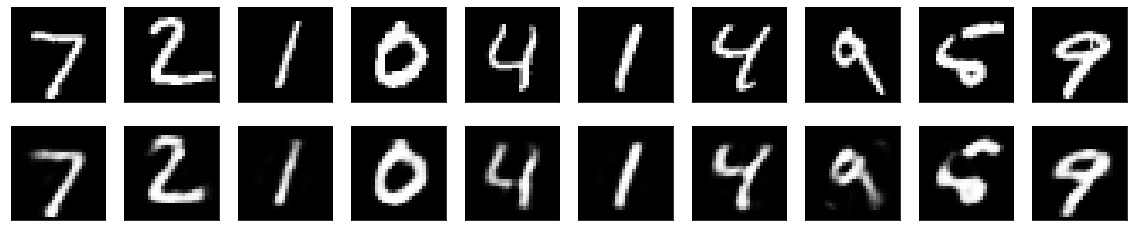

In [10]:
import matplotlib.pyplot as plt


n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(roundtrip_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

What about the compression? Let's check the sizes of the arrays.

In [11]:
encoded_imgs = autoencoder.transform(x_test)
print(f"x_test.shape[1]: {x_test.shape[1]}")
print(f"encoded_imgs.shape[1]: {encoded_imgs.shape[1]}")
cr = round((encoded_imgs.nbytes/x_test.nbytes), 2)
print(f"Compression ratio: 1/{1/cr:.0f}")

x_test.shape[1]: 784
encoded_imgs.shape[1]: 32
Compression ratio: 1/25
